In [ ]:
#Import the libraries
import pandas as pd
import os
import shutil

dataset_root = 'tom_and_jerry' 

base_path = 'tom_and_jerry/tom_and_jerry/tom_and_jerry'

challenges_path = os.path.join(dataset_root, 'challenges.csv')

challenges_df = pd.read_csv(challenges_path)
bad_images = set(challenges_df['image_name'].str.strip().tolist())

print(f"Total images to find: {len(bad_images)}")

if os.path.exists(base_path):
    print(f"✅ Success! Deep path verified: {base_path}")
    # List folders inside to be sure
    print(f"Folders found here: {os.listdir(base_path)}")
else:
    print(f"❌ Error! Path NOT found. Please double-check the folder names.")

Total images to find: 32
✅ Success! Deep path verified: tom_and_jerry/tom_and_jerry/tom_and_jerry
Folders found here: ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']


In [ ]:
filtered_dir = os.path.join(dataset_root, 'filtered_images')
os.makedirs(filtered_dir, exist_ok=True)

moved_count = 0
subfolders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

print("🚀 Starting cleanup deep scan...")

for folder in subfolders:
    folder_path = os.path.join(base_path, folder)
    
    if not os.path.exists(folder_path):
        print(f"⚠️ Skipping '{folder}' - folder not found at {folder_path}")
        continue
        
    print(f"Checking folder: {folder}...")
    
    for filename in os.listdir(folder_path):
        if filename.strip() in bad_images:
            source = os.path.join(folder_path, filename)
            destination = os.path.join(filtered_dir, filename)
            
            try:
                shutil.move(source, destination)
                moved_count += 1
            except Exception as e:
                pass

print(f"\n✅ Done! Moved {moved_count} images to: {filtered_dir}")

🚀 Starting cleanup deep scan...
Checking folder: jerry...
Checking folder: tom...
Checking folder: tom_jerry_0...
Checking folder: tom_jerry_1...

✅ Done! Moved 32 images to: tom_and_jerry/filtered_images


In [ ]:
print(f"Sample from challenges CSV: {list(bad_images)[:3]}")

# Check what the actual files look like in one folder
check_folder = os.path.join(base_path, 'jerry')
if os.path.exists(check_folder):
    print(f"Sample files in 'jerry' folder: {os.listdir(check_folder)[:3]}")
else:
    print(f"Error: Path {check_folder} does not exist.")

Sample from challenges CSV: ['frame2215.jpg', 'frame5408.jpg', 'frame2234.jpg']
Sample files in 'jerry' folder: ['frame100.jpg', 'frame1032.jpg', 'frame1033.jpg']


In [ ]:
img_height = 224
img_width = 224
batch_size = 16

# 1. Load the raw dataset
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# 2. Extract and save the class names NOW while they are accessible
class_names = train_ds_raw.class_names
print(f"Success! Detected classes: {class_names}")

# 3. Rescale pixel values (0-255 -> 0-1)
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))

# 4. Performance Optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets are normalized and optimized for training.")

Found 5446 files belonging to 4 classes.
Using 4357 files for training.
Found 5446 files belonging to 4 classes.
Using 1089 files for validation.
Success! Detected classes: ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']
Datasets are normalized and optimized for training.


In [5]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

In [13]:
from tensorflow.keras import models, layers, initializers, regularizers

num_classes = len(class_names)
l2_rate = 0.01

# 1. Define the Data Augmentation layers
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),     # Tom/Jerry can face either way
    layers.RandomRotation(0.1),          # Small tilts (10%)
    layers.RandomZoom(0.1),              # Slight zoom in/out
    layers.RandomContrast(0.1),          # Varying lighting/colors
])

# 2. Build the Advanced Model
model = models.Sequential([
    # Input Layer
    layers.Input(shape=(img_height, img_width, 3)),
    
    # --- ADD DATA AUGMENTATION HERE ---
    data_augmentation,
    
    # --- Block 1 ---
    layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', 
                  kernel_regularizer=regularizers.l2(l2_rate)),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    # --- Block 2 ---
    layers.Conv2D(64, (3, 3), kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2_rate)),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    # --- Block 3 ---
    layers.Conv2D(128, (3, 3), kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(l2_rate)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)), 
    
    # --- Classifier ---
    layers.Flatten(),
    layers.Dense(64, kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(l2_rate)),
    layers.BatchNormalization(),
    layers.Activation('relu'), 
    
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,632,132 (21.48 MB)

 Trainable params: 5,631,748 (21.48 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define the Early Stopping Callback
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

In [14]:
from tensorflow.keras import optimizers
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# This callback will cut the learning rate by half (factor=0.5) 
# if the validation loss doesn't improve for 2 epochs.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=2, 
    verbose=1,
    min_lr=1e-6
)

In [ ]:
epochs = 60
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/60
273/273 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.4092 - loss: 3.7528 - val_accuracy: 0.3085 - val_loss: 2.3169 - learning_rate: 0.0010
Epoch 2/60
273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.4824 - loss: 2.0104 - val_accuracy: 0.2277 - val_loss: 2.2954 - learning_rate: 0.0010
Epoch 3/60
273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.5403 - loss: 1.6821 - val_accuracy: 0.5638 - val_loss: 1.5512 - learning_rate: 0.0010
Epoch 4/60
273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.5846 - loss: 1.5065 - val_accuracy: 0.5950 - val_loss: 1.5205 - learning_rate: 0.0010
Epoch 5/60
273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.6507 - loss: 1.3412 - val_accuracy: 0.5960 - val_loss: 1.3936 - learning_rate: 0.0010
Epoch 6/60
273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.7000 - loss: 1.1915 - val_accuracy: 0.6667 - val_loss: 1.1943 - learning_rate: 0.0010
Epoch 7/60
273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.7266 - l

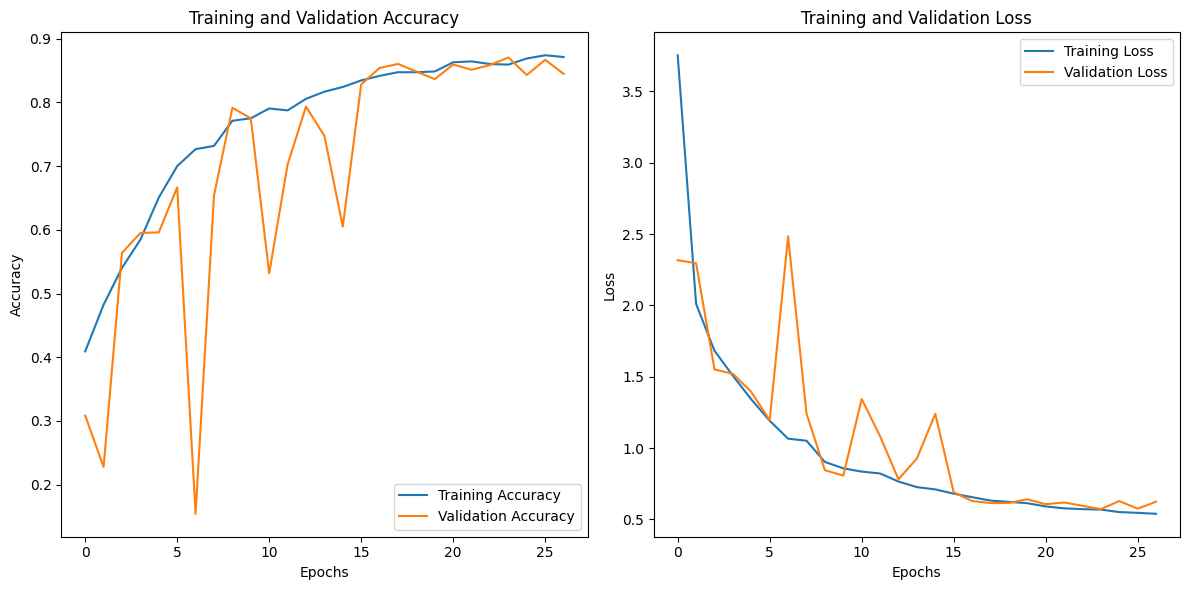

In [17]:
import matplotlib.pyplot as plt

# Retrieve results from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import tensorflow as tf
import os

# 1. Create the same mapping used during training
# ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']
label_map = {
    'jerry': 0,
    'tom': 1,
    'tom_jerry_0': 2,
    'tom_jerry_1': 3
}

# 2. Load the CSV and prepare file paths
test_df = pd.read_csv(os.path.join(dataset_root, 'challenges.csv'))

# Create absolute paths to the images sitting in your new filtered folder
test_df['full_path'] = test_df['image_name'].apply(
    lambda x: os.path.join(dataset_root, 'filtered_images', x.strip())
)

# Map the folder column to our integer labels
test_df['label_idx'] = test_df['folder'].map(label_map)

# Verify if paths are correct
print(f"Sample path: {test_df['full_path'].iloc[0]}")
print(f"File exists: {os.path.exists(test_df['full_path'].iloc[0])}")

Sample path: tom_and_jerry/filtered_images/frame360.jpg
File exists: True


In [34]:
def load_and_preprocess_image(path, label):
    # Read the file
    image = tf.io.read_file(path)
    # Decode to tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize to match your model input
    image = tf.image.resize(image, [img_height, img_width])
    # Normalize (0 to 1)
    image = image / 255.0
    return image, label

# Create the TensorFlow Dataset object
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['full_path'].values, test_df['label_idx'].values)
)

# Apply the preprocessing
test_ds = test_ds.map(load_and_preprocess_image)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Test dataset pipeline is ready!")

Test dataset pipeline is ready!


In [35]:
# Evaluate
print("Evaluating on Challenge Test Set...")
test_loss, test_acc = model.evaluate(test_ds)

print(f"\n✅ Final Results:")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Evaluating on Challenge Test Set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9375 - loss: 0.3054

✅ Final Results:
Test Accuracy: 93.75%
Test Loss: 0.3054
